In [6]:
# import CartPole.py from local directory
import CartPole, sf3utility
import matplotlib.collections
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate, scipy.stats.qmc, scipy.optimize
import random, copy

plt.rcParams["font.family"] = "Georgia"
#plt.rcParams['figure.figsize'] = [9.0, 7.0]
#plt.rcParams['figure.dpi'] = 400

# store results for later
cache = {}

In [7]:
# allows nice plots that can be redrawn
%matplotlib notebook

# Task 2.3 - Linear Control

Now I am interested in controlling the cartpole system using a linear policy p(X) = p.X to set the action at each timestep. The vector p is determined by minimising a loss function L, defined by summing a point loss function evaluated at each time step over a certain timeframe: $L = \sum_{i=1}^N l(X_i)$ with $l(X) = 1 - e^{ - X^2 / 2 \sigma_l^2 }$.

First, note that finding L involves repeated evaluation of the cartpole dynamics as defined in `perform_action`. To speed up the fitting process, I reimplemented the Euler integrator using the RK4 method which improves accuracy and executes in roughly half the time - see `perform_action_RK4(state)` in `CartPole.py`.

Also note that the provided loss function can ascribe a large loss to a cartpole in the desired configuration if the pole angle is not zero but actually a multiple of 2 pi. Therefore an improved loss function could be periodic in the pole angle variable, similar to the correction used in the kernel functions in task 2.1. The same is true for the linear policy: p.X could be nonzero in the desired configuration if the pole angle is a multiple of 2 pi.

Next, I implemented the loss function L and created some contour plots to visualise how it varied across the policy space. I then used `scipy.optimize.minimize` with the Nelder-Mead method to find an optimal setting of the policy vector p. I made several calls to the minimize function, each starting from a different initial value of the p vector, and took the one that gave the smallest loss. I also implemented an optimisation where the loss function L would return the maximum value if any of the elements of the state vector grew too large. This helped to reduce the number of `perform_action` calls that needed to be made as poor polcies were identified earlier in the process.

In [8]:
def rollout_loss( initial_state, p ):
    
    state = initial_state
    sim_seconds = 10
    sim_steps = int( sim_seconds / 0.2 )
    loss = 0
    
    for i in range( sim_steps ):
        
        if np.any( np.abs(state) > np.array([10,40,50,1e+3,1e+3]) ):
            return sim_steps
        
        state[4] = p @ state
        loss += CartPole.loss( state[:4] )
        state = CartPole.perform_action_RK4( state )
    
    return loss

## Create Loss Contour Plots

In [9]:
# number of steps to vary the intial conditions across their range
Nsteps = 10

initial_state = np.array( [0.2,0,0.2,0,0] )

# setup some p vectors

p0 = np.linspace( -1, 4, num=Nsteps )
p1 = np.linspace( -1, 4, num=Nsteps )
p2 = np.array( [17.06] ) # np.linspace( 0, 30, num=Nsteps )
p3 = np.array( [2.66] ) # np.linspace( 0, 4, num=Nsteps )
p4 = np.array( [0] )

# create array of p vectors

ps1 = np.array( np.meshgrid( p0, p1, p2, p3, p4 )).T.squeeze()
ps1_flat = ps1.reshape( (Nsteps**2,5) )

losses1_flat = np.array([ rollout_loss( initial_state, p ) for p in ps1_flat ])
losses1 = losses1_flat.reshape( (Nsteps, Nsteps) )

# setup some p vectors

p0 = np.array( [0.75] ) # np.linspace( -4, 4, num=Nsteps )
p1 = np.array( [1.44] ) # np.linspace( -4, 4, num=Nsteps )
p2 = np.linspace( 10, 30, num=Nsteps )
p3 = np.linspace( 2, 4, num=Nsteps )
p4 = np.array( [0] )

# create array of p vectors

ps2 = np.array( np.meshgrid( p0, p1, p2, p3, p4 )).T.squeeze()
ps2_flat = ps2.reshape( (Nsteps**2,5) )

losses2_flat = np.array([ rollout_loss( initial_state, p ) for p in ps2_flat ])
losses2 = losses2_flat.reshape( (Nsteps, Nsteps) )

<IPython.core.display.Javascript object>


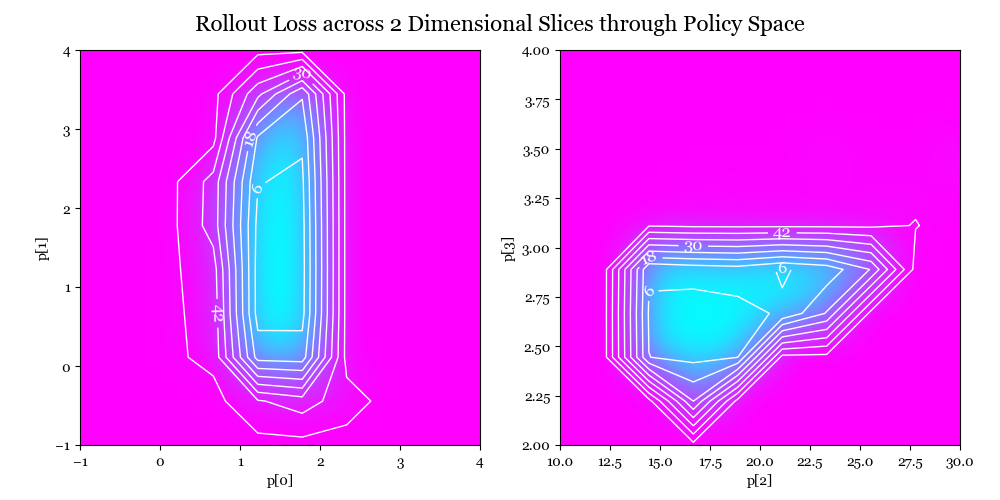

Text(0.5, 0.95, 'Rollout Loss across 2 Dimensional Slices through Policy Space')

In [10]:
fig, (ax1, ax2) = plt.subplots( 1, 2, num=51, figsize=(10,5) )
fig.subplots_adjust( top=0.9, bottom=0.11, left=0.08, right=0.96 )

ax1.imshow( losses1, interpolation="bicubic", extent=(-1, 4, -1, 4), aspect='auto', cmap="cool", origin='lower' )
contour1 = ax1.contour( ps1[:,0,0], ps1[0,:,1], losses1, colors="white", linewidths=1 )
ax1.clabel( contour1, contour1.levels[1::2], inline=True, fontsize=12 )  
ax1.set_xlabel( "p[0]" )
ax1.set_ylabel( "p[1]" )

ax2.imshow( losses2, interpolation="bicubic", extent=(10, 30, 2, 4), aspect='auto', cmap="cool", origin='lower' )
contour2 = ax2.contour( ps2[0,:,2], ps2[:,0,3], losses2, colors="white", linewidths=1 )
ax2.clabel( contour2, contour2.levels[1::2], inline=True, fontsize=12 )   
ax2.set_xlabel( "p[2]" )
ax2.set_ylabel( "p[3]" )

fig.text(0.5, 0.95, 'Rollout Loss across 2 Dimensional Slices through Policy Space', ha='center', va='center', fontsize=16)

Above I have plotted the total loss evaluated at values of the p vector across two orthogonal slices through one of the minimums. The optimal value of the p vector found by the optimiser is the intersection of these two planes. I was lucky to find this minimum and will probably not find any more since the policy space is so large and the portion where the loss isn't maximal is a tiny fraction of it - magenta shows maximal loss and cyan anything below. 

One thing about this loss function is that there are large areas with very small gradients, which would make classical machine learning techniques like gradient descent difficult to apply. One possibility is to try the log of the loss function which might help regularise the gradients, or adjust the loss function so that it doesn't reach a maximum as the current one does. I used the Nelder-Mead method so that the gradients weren't a factor, but noted that a lot of bad policies were found with this method. Using many different starting locations allowed me to find decent policies but if this hadn't worked I would next try to adjust the definition of the problem to help the optimiser work better.

## Optimise Policy Vector

In [11]:
%%time

initial_state = np.array( [ 0.2, 0, 0.2, 0, 0 ] )
#initial_state = np.array( [1,0,0.5,0,0] )

pad0 = lambda p : np.pad( p, (0,1) )
rollout_loss_from_initial = lambda p : rollout_loss( initial_state, pad0(p) )

min_loss = 999999
best_p = None

for i in range(100):

    p0     = np.random.rand( (4) ) - 0.5
    result = scipy.optimize.minimize( rollout_loss_from_initial, p0, method="Nelder-Mead" )
    
    end_loss = rollout_loss_from_initial( result["x"] )
    
    if end_loss < min_loss:
        best_p = result["x"]
        min_loss = end_loss
        
    print(best_p, min_loss)

p = best_p

[-0.04833049 -0.72811612 -0.00564515 -0.00964072] 49.04993868521045
[-0.04833049 -0.72811612 -0.00564515 -0.00964072] 49.04993868521045
[ 0.04744076 -0.17624254 -0.00708305  0.02977199] 48.62246087222132
[ 0.04744076 -0.17624254 -0.00708305  0.02977199] 48.62246087222132
[ 0.04744076 -0.17624254 -0.00708305  0.02977199] 48.62246087222132
[ 0.04744076 -0.17624254 -0.00708305  0.02977199] 48.62246087222132
[ 0.04744076 -0.17624254 -0.00708305  0.02977199] 48.62246087222132
[ 0.04744076 -0.17624254 -0.00708305  0.02977199] 48.62246087222132
[ 0.04744076 -0.17624254 -0.00708305  0.02977199] 48.62246087222132
[ 0.04744076 -0.17624254 -0.00708305  0.02977199] 48.62246087222132
[ 0.04744076 -0.17624254 -0.00708305  0.02977199] 48.62246087222132
[ 0.04744076 -0.17624254 -0.00708305  0.02977199] 48.62246087222132
[ 0.04744076 -0.17624254 -0.00708305  0.02977199] 48.62246087222132
[ 0.04744076 -0.17624254 -0.00708305  0.02977199] 48.62246087222132
[ 0.04744076 -0.17624254 -0.00708305  0.02977199

## Simulation Using Optimised Policy Vector

<IPython.core.display.Javascript object>


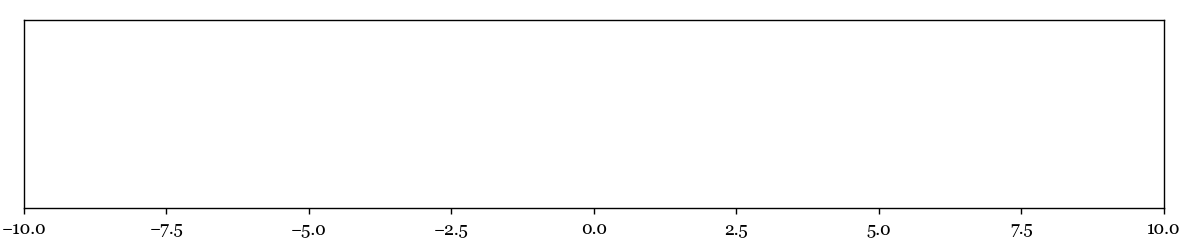

In [171]:
cart_pole = CartPole.CartPole( visual=True, save_frames=False, fig_num=48 )

state = np.array( [ 0, 0, 0.65, 0, 0 ] )
#p = np.array( [0.76187176,  1.19122763, 16.3309897 ,  2.49340076, 0] ) # optimised from theta=0.1
#p = np.array( [0.78060594,  1.22653498, 16.50730499,  2.52886043, 0] ) # optimised from theta=0.5
p = np.array( [0.75971638,  1.44284499, 17.05744679,  2.66183469, 0] ) # optimised from theta=0.5
#p = np.array ( [ -0.33143221, -0.42699904, -0.09783966,  0.10055861, 0 ] )
#p = np.array( [2.13646362,  2.594651,   17.62534208,  3.10145759, 0] ) # optimised on model
#p = np.array( [2.29932985, 3.80458197, 22.57529485, 3.9609772, 0] ) # better? optimised on model

#p = np.array( [2.29932985, 3.80458197, 22.57529485, 3.9609772, 0] ) # optimised on model

#p = - np.array( [-0.20792587, -0.4554855, -12.8760437,  -1.92181886, 0] ) # dlqr!!
#p = - np.array( [-0.42004789,  -0.754576  , -13.5778077 ,  -2.08834533, 0] ) # dlqr!! small R
#p = - np.array( [ -0.02581708,  -0.1272267 , -11.95653773,  -1.73874922, 0] ) # dlqr!! big R
p = - np.array( [ -0.02533298,  -0.14828819, -12.0167036 ,  -1.7515722, 0] ) # dlqr custom q

#p = np.array([5.15790716,  0.31123075, -0.43806554, -2.78868611, 0])

cart_pole.set_state( state )

cart_pole._render()


In [172]:
for i in range(50): 

    clipped_state = state
    clipped_state[0] = np.clip( state[0], -2, 2 )

    state[4] = p @ clipped_state
    state = CartPole.perform_action_RK4( state )
    cart_pole.set_state( state[:4] )
    cart_pole._render()

## Stabilised Range of Initial Conditions

The optimised policy vector that my search returned is p = [ 0.76,  1.44, 17.06,  2.66 ]. This setting of p is able to stablise the cartpole from initial angular displacements around 0.6 and initial cart displacements around 2 metres. These ranges can also be increased by favourable initial linear and angular velocities. Increasing the initial cart displacement beyond this resulted in a large initial force that caused the system to lose control, as the contribution from the cart position became too large. However, we can leverage the translational invariance of the system to avoid this: by clipping the first element of the state vector between -2 and 2 just before it is fed into the policy function p(X), the policy thinks it is only at most 2 metres from the equilibrium. So it still moves the cart towards the desired state at the origin, but without overdoing it. However, this is no longer a truly linear model.

Note that a discrete-time linear-quadratic regulator could also be employed to find a policy vector to avoid the long optimisation process but this is beyond my experience.

<IPython.core.display.Javascript object>


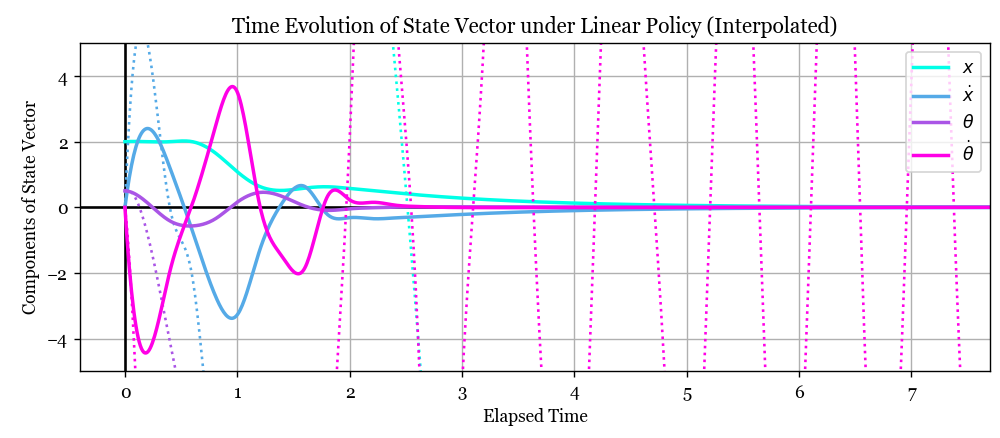

(-0.4, 7.7)

In [9]:
fig, ax = plt.subplots(1, 1, num=49, figsize=(8,3.5))
fig.subplots_adjust(top=0.9, bottom=0.15, left=0.08, right=0.99)
sf3utility.setup_phase_portrait( ax )

# small oscillations about stable equilibrium

state = np.array( [40, 0, 0.5, 0, 0] )
unclipped_state = np.array( [40, 0, 0.5, 0, 0] )

states = []
unclipped_states = []
time = []

for i in range(40):
    
    states.append( state )
    unclipped_states.append( unclipped_state )
    time.append( i * 0.2 )

    clipped_state = state
    clipped_state[0] = np.clip( state[0], -2, 2 )

    state[4] = p @ clipped_state
    state = CartPole.perform_action_RK4( state )
    
    
    unclipped_state[4] = p @ unclipped_state
    unclipped_state = CartPole.perform_action_RK4( unclipped_state )
    

states = np.array( states )
unclipped_states = np.array( unclipped_states )
time = np.array( time )

x = time
y = states
y2 = unclipped_states

col_lerp = np.linspace(0, 1, 4)[np.newaxis].T
colours = ( 1 - col_lerp ) * np.array( [0, 255, 231, 255] )/255 + col_lerp * np.array( [255, 0, 230, 255] )/255

labels = ["$x$","$\dot{x}$","$θ$","$\dot{θ}$"]

for i in range(4):
    
    f = scipy.interpolate.interp1d(x, y[:,i], kind='cubic')

    xnew = np.linspace(0, time[-1], 800)
    
    ax.plot( xnew, f(xnew), color=colours[i], label=labels[i], linewidth=2 )
    
    
    f2 = scipy.interpolate.interp1d(x, y2[:,i], kind='cubic')
    
    ax.plot( xnew, f2(xnew), color=colours[i], linestyle="dotted" )

ax.set_title( "Time Evolution of State Vector under Linear Policy (Interpolated)" )
ax.set_xlabel( "Elapsed Time" )
ax.set_ylabel( "Components of State Vector" )
ax.legend(loc="upper right")

ax.set_ylim( -5, 5 )
ax.set_xlim( -0.4, 7.7 )

## State Vector Evolution with Time

In the plot above each solid line is one component of the state vector as they vary under the linear policy, starting from an intial state X = [ 40, 0, 0.5, 0 ]. All the components are brought to zero as desired and you can also see the horizontal part of the cyan line (representing the cart position) where the position clipping is coming into effect. The dotted lines show the states without the position clipping, and are highly unstable.

# Task 2.4 - Model Predictive Control

I tried to use the same optimised policy vector p to control the modelled dynamics, and found that the same policy vector was able to bring the modelled system to the desired state but took slightly longer to do so.

## Refitting Nonlinear Model

In [85]:
N = 512 * 8

# set the random seed and create the sobol sequence generator
sobol_engine = scipy.stats.qmc.Sobol( d=5, seed=4 )

# get N initial states spaced in the recommended ranges
X = X_sobol = initial_states = (sobol_engine.random_base2( m=int(np.log2(N)) ) - 0.5 ) * 2 * np.array( [ 10, 20, np.pi, 20, 15 ] )

# generate the changes in state from these states
Y = np.array( [ CartPole.perform_action_RK4( state ) - state for state in initial_states ] )


M = 32 * 32
kernel_centres = X[:M]


sigma = np.std( X, axis=0 )

def K( X, Xp, sigma = sigma ):
    
    # get squared differences and substitute angle one for periodic version
    d2 = ( (X - Xp) / sigma ) ** 2
    d2[:,0] = 0
    d2[:,2] = (np.sin( 0.5 * ( X[:,2] - Xp[:,2] ) ) / sigma[2] ) ** 2
    
    # divide rows by 2 sigma and return exponential of negative sum along rows
    return np.exp( - 0.5 * np.sum( d2, axis=1 ) )
    
    
# loop over the kernel centres and evaluate the K function across all the Xs at each
Kmn = np.zeros( (M,N) )
for i, kernel_centre in enumerate( kernel_centres ):
    
    Kmn[i] = K( X, kernel_centre[np.newaxis] )
    
# same as above but only use first M vectors from X
Kmm = np.zeros( (M,M) )
for i, kernel_centre in enumerate( kernel_centres ):
    
    Kmm[i] = K( X[:M], kernel_centre[np.newaxis] )
    
    
l = 1e-4

KmnKnm = Kmn @ Kmn.T
a = KmnKnm + l * Kmm
b = Kmn @ Y

alpha_m = np.linalg.lstsq( a, b, rcond=None )[0]

def nonlinear_model( state ):
    
    kernels = K( state[np.newaxis], kernel_centres )
    
    weighted_sums = kernels @ alpha_m
    
    return weighted_sums.squeeze()

## Simulation Using Modelled Dynamics

<IPython.core.display.Javascript object>


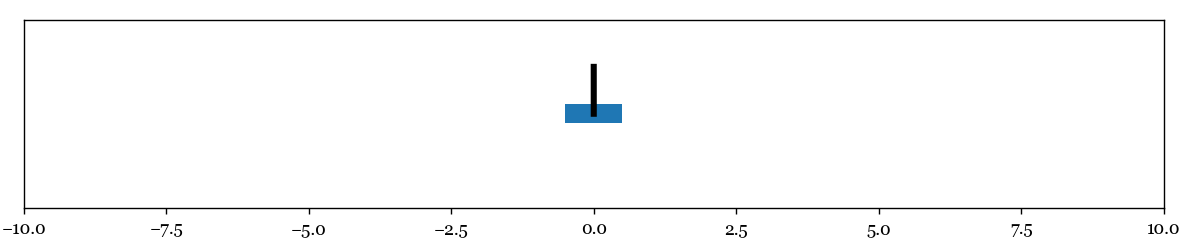

In [72]:
cart_pole = CartPole.CartPole( visual=True, save_frames=False, fig_num=58 )

state = np.array( [ 8, 0, -0.6, 0, 0 ] )
#p = np.array( [0.76187176,  1.19122763, 16.3309897 ,  2.49340076, 0] ) # optimised from theta=0.1
#p = np.array( [0.75971638,  1.44284499, 17.05744679,  2.66183469, 0] ) # optimised from theta=0.5
#p = np.array( [ -0.33143221, -0.42699904, -0.09783966,  0.10055861, 0 ] )
#p = np.array( [2.13646362,  2.594651,   17.62534208,  3.10145759, 0] ) # optimised on model
#p = np.array( [2.29932985, 3.80458197, 22.57529485, 3.9609772, 0] ) # better? optimised on model
p = np.array( [ 2.42158373, 3.81812947, 22.41281719, 3.95562641, 0 ] ) # optimised on model with 8 second horizon
#p = np.array( [ 2.77273844, 4.15835948, 23.64017977, 4.15351885, 0] ) # optimised on model with larger initial displacement
#p = np.array( [11.91259675, 8.02276575, 29.81324002, 5.60813997, 0] ) # different initial state (bad)

cart_pole.set_state( state )

cart_pole._render()

In [75]:
for i in range(50):

    clipped_state = state
    clipped_state[0] = np.clip( state[0], -2, 2 )

    state[4] = p @ clipped_state
    #state = nonlinear_model( state ) + state
    state = CartPole.perform_action_RK4( state )
    cart_pole.set_state( state[:4] )
    cart_pole._render()

## Create Model Rollout Loss Function

In [13]:
def model_rollout_loss( initial_state, p ):
    
    state = initial_state
    sim_seconds = 8
    sim_steps = int( sim_seconds / 0.2 )
    loss = 0
    
    for i in range( sim_steps ):
        
        if np.any( np.abs(state) > np.array([10,40,50,1e+3,1e+3]) ):
            return sim_steps
        
        state[4] = p @ state
        loss += CartPole.loss( state[:4] )
        state = nonlinear_model( state ) + state
    
    return loss

## Optimise the Policy Vector using Modelled Dynamics

In [84]:
# %%time

# # initial_state = np.array( [ 0.2, 0, 0.2, 0, 0 ] )
# initial_state = np.array( [ 0.4, 0, -0.4, 0, 0 ] ) # larger initial state for better generality
# #initial_state = np.array( [1,0,0.5,0,0] )

# pad0 = lambda p : np.pad( p, (0,1) )
# model_rollout_loss_from_initial = lambda p : model_rollout_loss( initial_state, pad0(p) )

# min_loss = 999999
# best_p = None

# for i in range(100):

#     p0     = np.array( [0.78060594,  1.22653498, 16.50730499,  2.52886043] ) + np.random.rand( 4 ) * 3 - 1.5
#     result = scipy.optimize.minimize( model_rollout_loss_from_initial, p0, method="Nelder-Mead" )
    
#     end_loss = result["fun"]
    
#     if end_loss < min_loss:
#         best_p = result["x"]
#         min_loss = end_loss
        
#     print(best_p, min_loss)
    
# p = pad0(best_p)

## Model-Based Optimisation

I changed the rollout loss evaluation function to use the modelled dynamics, and then re-ran the optimisation process to find a new policy vector noting that the process was much faster because the model is cheaper to evaluate than the actual dynamics (this provides motivation for performing model predictive control). Thinking that the model dynamics aren't too different to the real ones, I used the previous optimal policy vector as the starting point for the optimisation and found the following optimal policy vector: p = [ 2.42, 3.82, 22.41, 3.96 ].

<IPython.core.display.Javascript object>


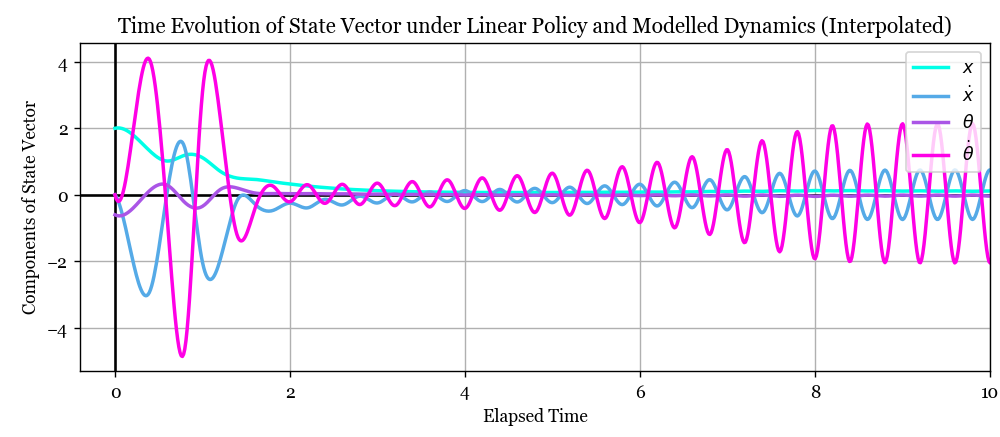

(-0.4, 10.0)

In [87]:
fig, ax = plt.subplots(1, 1, num=66, figsize=(8,3.5))
fig.subplots_adjust(top=0.9, bottom=0.15, left=0.08, right=0.99)
sf3utility.setup_phase_portrait( ax )

# small oscillations about stable equilibrium

state = np.array( [ 8, 0, -0.6, 0, 0 ] )

states = []
time = []

for i in range(55):
    
    states.append( state )
    time.append( i * 0.2 )

    clipped_state = state
    clipped_state[0] = np.clip( state[0], -2, 2 )

    state[4] = p @ clipped_state
    state = nonlinear_model( state ) + state

states = np.array( states )
time = np.array( time )

x = time
y = states

col_lerp = np.linspace(0, 1, 4)[np.newaxis].T
colours = ( 1 - col_lerp ) * np.array( [0, 255, 231, 255] )/255 + col_lerp * np.array( [255, 0, 230, 255] )/255

labels = ["$x$","$\dot{x}$","$θ$","$\dot{θ}$"]

for i in range(4):
    
    f2 = scipy.interpolate.interp1d(x, y[:,i], kind='cubic')

    xnew = np.linspace(0, time[-1], 800)
    
    ax.plot( xnew, f2(xnew), color=colours[i], label=labels[i], linewidth=2 )

ax.set_title( "Time Evolution of State Vector under Linear Policy and Modelled Dynamics (Interpolated)" )
ax.set_xlabel( "Elapsed Time" )
ax.set_ylabel( "Components of State Vector" )
ax.legend(loc="upper right")

# ax.set_ylim( -5, 5 )
ax.set_xlim( -0.4, 10 )

Above I have plotted the time evolution of the state vector under the model-optimised linear policy, and using the modelled dynamics. Although the cart and pole positions are relatively stable at the desired configuration, there are oscillations in the linear and angular velocities about the equilibrium, although these stop growing after 8 seconds. These oscillations are of period 0.4s so are formed by overshoot and correction over 2 subsequent calls to `perform_action`; I think these are acceptable as they don't cause the cartpole to really deviate from the desired configuration.

However, if I wanted to avoid this oscillation the loss function could be adjusted to discourage it. For example, the total rollout loss function could ignore the first few seconds and only include states afterwards. This could select for policies that take a bit longer to get the pole upright and stable, but are subsequently able to hold it completely still. Other adjustments to the loss function could include penalising force input also, to encourage efficient control.

In general, the model predictive control method has not performed as well, with these oscillations proving very hard to avoid. The other big problem with the model-optimised policy is that it's much more sensitive to initial conditions: carefully selected small initial displacements can lead to divergence. So it seems that using the model for dynamics has caused the policy to miss some of the generality that the previous policy was able to capture, maybe due to the model being ignorant of certain features of the true data.

<IPython.core.display.Javascript object>


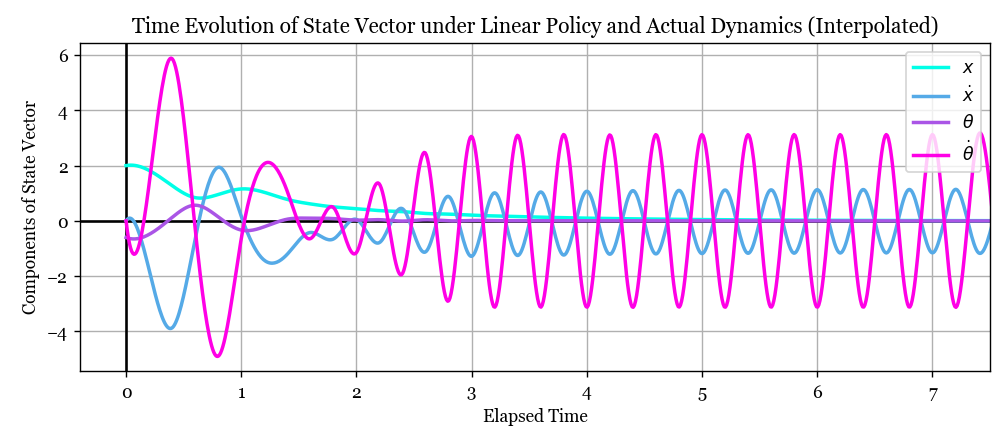

(-0.4, 7.5)

In [88]:
fig, ax = plt.subplots(1, 1, num=64, figsize=(8,3.5))
fig.subplots_adjust(top=0.9, bottom=0.15, left=0.08, right=0.99)
sf3utility.setup_phase_portrait( ax )

# small oscillations about stable equilibrium

state = np.array( [ 8, 0, -0.6, 0, 0 ] )

states = []
time = []

for i in range(40):
    
    states.append( state )
    time.append( i * 0.2 )

    clipped_state = state
    clipped_state[0] = np.clip( state[0], -2, 2 )

    state[4] = p @ clipped_state
    state = CartPole.perform_action_RK4( state )

states = np.array( states )
time = np.array( time )

x = time
y = states

col_lerp = np.linspace(0, 1, 4)[np.newaxis].T
colours = ( 1 - col_lerp ) * np.array( [0, 255, 231, 255] )/255 + col_lerp * np.array( [255, 0, 230, 255] )/255

labels = ["$x$","$\dot{x}$","$θ$","$\dot{θ}$"]

for i in range(4):
    
    f2 = scipy.interpolate.interp1d(x, y[:,i], kind='cubic')

    xnew = np.linspace(0, time[-1], 800)
    
    ax.plot( xnew, f2(xnew), color=colours[i], label=labels[i], linewidth=2  )

ax.set_title( "Time Evolution of State Vector under Linear Policy and Actual Dynamics (Interpolated)" )
ax.set_xlabel( "Elapsed Time" )
ax.set_ylabel( "Components of State Vector" )
ax.legend(loc="upper right")

# ax.set_ylim( -5, 5 )
ax.set_xlim( -0.4, 7.5 )

## Return to Actual Dynamics

I then tried to use the policy vector optimised on the model to control the actual dynamics. The oscillations in linear  and angular velocity have become larger. However, the pole and cart positions are sucessfully controlled to the desired state. Again, the policy is more sensitive to intial conditions. I would say that the model predictive control approach has worked well but definately has suffered a loss in stability and generality.